In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.append("../")

from scipy.optimize import curve_fit
from src.enablence_mux import EBMUX

In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9

In [3]:
grid_array_diff = np.mean(np.diff(target_grid_array))
grid_array_diff

1.1446666666666693e-09

In [4]:
sppd_mc_data = xr.open_dataset("../simulation_data/sppd_clm_controller_montecarlo_spec_v0p5_with_binning_20240513_0p1.nc")
sppd_mc_data = xr.open_dataset("../simulation_data/sppd_clm_controller_montecarlo_spec_v0p5_no_mux_tec_20240511_0p1.nc")

In [5]:
sppd_mc_data

<xarray.Dataset>
Dimensions:                      (idd_iter: 251, idd_laser: 16, idd_eb: 1,
                                  idd_sppd: 1, idd_wpe: 1, observable_stat: 16,
                                  controller_observable: 5, lin_sweep_range: 2,
                                  idd_mux: 1, idd_bw_lambda: 1)
Coordinates:
  * idd_iter                     (idd_iter) int32 0 1 2 3 4 ... 247 248 249 250
  * observable_stat              (observable_stat) object 'std' ... 'min_agg_2'
  * idd_laser                    (idd_laser) int32 0 1 2 3 4 ... 11 12 13 14 15
  * controller_observable        (controller_observable) object 'drive_curren...
  * lin_sweep_range              (lin_sweep_range) float64 0.1 0.2
  * idd_mux                      (idd_mux) int32 0
  * idd_eb                       (idd_eb) int32 0
  * idd_sppd                     (idd_sppd) int32 0
  * idd_bw_lambda                (idd_bw_lambda) int32 0
  * idd_wpe                      (idd_wpe) int32 0
Data variables:
    enablence_mux_mc             (idd_iter, idd_laser, idd_eb) float64 ...
    sppd_laser_mc                (idd_iter, idd_laser, idd_sppd) float64 ...
    wpe_slope_factor_mc          (idd_iter, idd_laser, idd_wpe) float64 ...
    dfb_backside_temperature_mc  (idd_iter) float64 ...
    data_statistics_array        (idd_mux, idd_iter, idd_eb, idd_sppd, idd_bw_lambda, idd_wpe, lin_sweep_range, controller_observable, observable_stat, idd_laser) float64 ...
Attributes:
    description:  SPPD CLM Controller Monte Carlo Simulation simulations with...

In [35]:
enablence_mux_bw_lambda = np.array([20])/17*0.1e-9
enablence_mux_3sigma = np.array([17])/17*0.1e-9
sppd_laser_3sigma = np.array([27])/17*0.1e-9
no_mux = np.array([0])
wpe_slope_3sigma = np.array([0.15])
lin_sweep_val_range = np.array([0.1, 0.2])
mpd_current_clamp_range = np.array([40e-3])

no_lasers = 16
no_iterations = 251

no_bins = 61

In [7]:
def gaus(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))
    
def gaussian_quality(x_data, no_bins):
    x_data_temp = x_data[(-30 < x_data)]
    clipped_data = x_data_temp[(x_data_temp < 30)]
    hist, bin_edges = np.histogram(clipped_data, bins = no_bins)
    hist = hist/sum(hist)
    n = len(hist)
    x_hist=np.zeros((n),dtype=float) 
    
    for ii in range(n):
        x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2
    y_hist=hist

    def gaus(X,C,X_mean,sigma):
        return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

    #Gaussian least-square fitting process
    param_optimised,_ = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)    

    x_hist_2 = np.linspace(-50, 50, 500)
    
    y_hist_2 = gaus(x_hist_2,*param_optimised) 
    return param_optimised, x_hist_2, y_hist_2

def gaussian_quality_2(x_data, no_bins, x_hist_2 = np.linspace(100, 150, num=500)):
    hist, bin_edges = np.histogram(x_data, bins = no_bins)
    hist = hist/sum(hist)
    n = len(hist)
    x_hist=np.zeros((n),dtype=float) 
    
    for ii in range(n):
        x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2
    y_hist=hist

    def gaus(X, C, X_mean, sigma):
        return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 
    
    #Gaussian least-square fitting process
    param_optimised,_ = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)    
    
    y_hist_2 = gaus(x_hist_2, *param_optimised) 
    return param_optimised, x_hist_2, y_hist_2

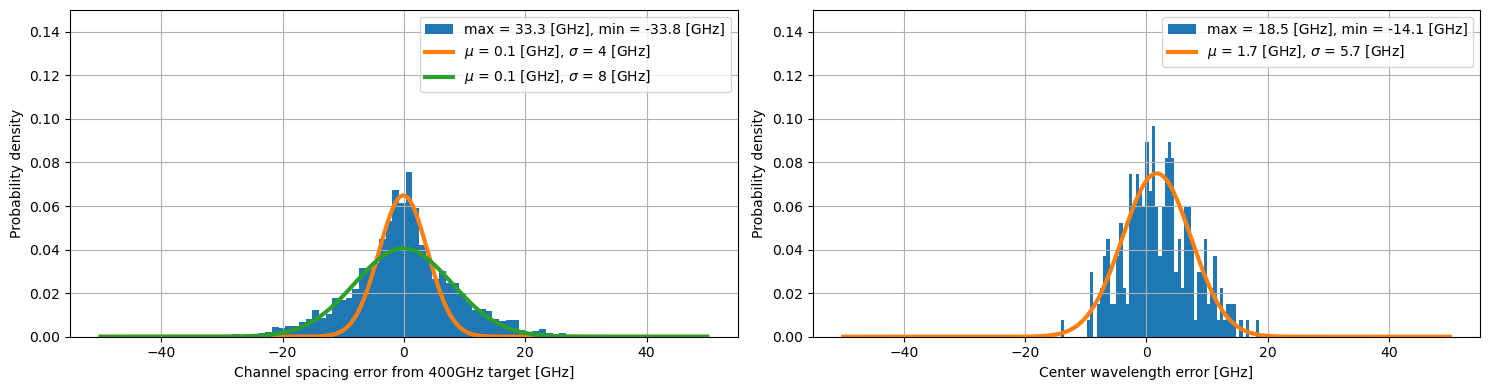

In [8]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
adjacent_error = (np.diff(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = 'mean', controller_observable = 'enablence_output_lambda').values, axis = -1) - grid_array_diff).flatten()
param_optimised, x_hist, y_hist = gaussian_quality(adjacent_error/0.1e-9*17, no_bins)
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

x_hist_2 = x_hist
y_hist_2 = gaus(x_hist, param_optimised[0]*1.2, param_optimised[1], 4)

x_hist_3 = x_hist
y_hist_3 = gaus(x_hist, param_optimised[0]*0.75, param_optimised[1], 8)

plt.hist(adjacent_error/0.1e-9*17, bins = no_bins, density = True, label=f'max = {np.max(adjacent_error/0.1e-9*17):.1f} [GHz], min = {np.min(adjacent_error/0.1e-9*17):.1f} [GHz]')
# plt.plot(x_hist, y_hist, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = {sigma_lambda_ch:.1f} [GHz]')
plt.plot(x_hist_2, y_hist_2, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 4 [GHz]')
plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.ylim([0, 0.15])
plt.grid(True)
plt.xlabel('Channel spacing error from 400GHz target [GHz]')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()


plt.subplot(1, 2, 2)
center_wavelength_error = (np.mean(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = 'mean', controller_observable = 'enablence_output_lambda').values, axis = -1) - np.mean(target_grid_array)).flatten()
param_optimised, x_hist, y_hist = gaussian_quality(center_wavelength_error/0.1e-9*17, no_bins)
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

x_hist_2 = x_hist
y_hist_2 = gaus(x_hist, param_optimised[0]*2, param_optimised[1], 4)

plt.hist(center_wavelength_error/0.1e-9*17, bins = no_bins, density = True, label=f'max = {np.max(center_wavelength_error/0.1e-9*17):.1f} [GHz], min = {np.min(center_wavelength_error/0.1e-9*17):.1f} [GHz]')
plt.plot(x_hist, y_hist*2.0, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = {sigma_lambda_ch:.1f} [GHz]')

plt.ylim([0, 0.15])
plt.grid(True)
plt.xlabel('Center wavelength error [GHz]')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()

plt.show()

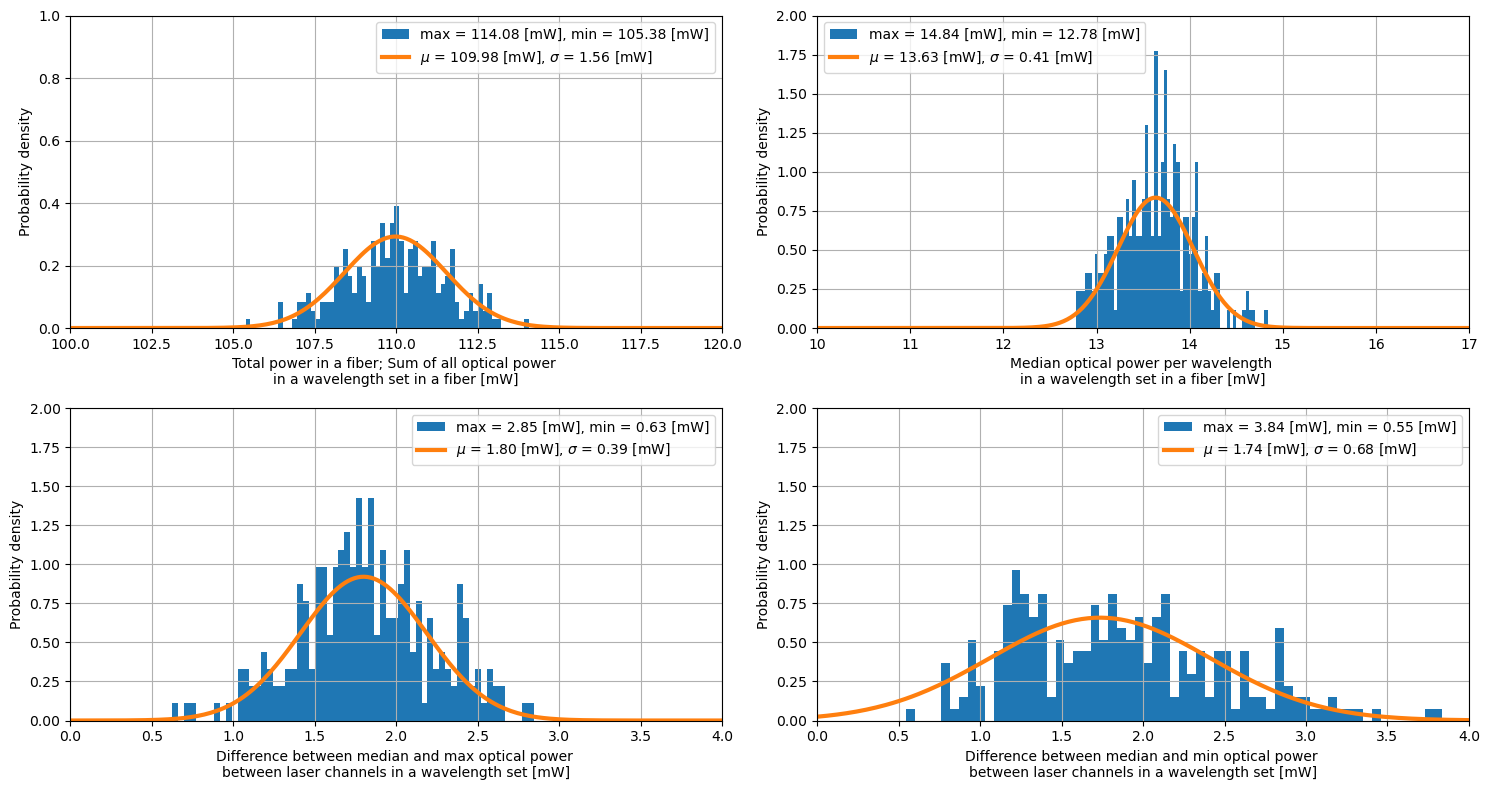

In [12]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
total_fiber_power = (np.sum(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()/2*10**(-0.05)
param_optimised, x_hist, y_hist = gaussian_quality_2(total_fiber_power*1e3, no_bins)
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

plt.hist(total_fiber_power*1e3, bins = no_bins, density = True, label=f'max = {np.max(total_fiber_power)*1e3:.2f} [mW], min = {np.min(total_fiber_power)*1e3:.2f} [mW]')
plt.plot(x_hist, y_hist*8, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.2f} [mW], $\sigma$ = {sigma_lambda_ch:.2f} [mW]')
# plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.xlim([100, 120])
plt.ylim([0,1])
plt.grid(True)
plt.xlabel('Total power in a fiber; Sum of all optical power \nin a wavelength set in a fiber [mW]')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(2, 2, 2)
median_ch_optical_power = (np.median(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05)
param_optimised, x_hist, y_hist = gaussian_quality_2(median_ch_optical_power*1e3, no_bins, x_hist_2=np.linspace(10, 20, num=500))
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

plt.hist(median_ch_optical_power*1e3, bins = no_bins, density = True, label=f'max = {np.max(median_ch_optical_power)*1e3:.2f} [mW], min = {np.min(median_ch_optical_power)*1e3:.2f} [mW]')
plt.plot(x_hist, y_hist*25, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.2f} [mW], $\sigma$ = {sigma_lambda_ch:.2f} [mW]')
# plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.xlim([10, 17])
plt.ylim([0,2])
plt.grid(True)
plt.xlabel('Median optical power per wavelength \nin a wavelength set in a fiber [mW]')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(2, 2, 3)
max_median_ch_optical_power = (np.max(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05) - (np.median(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05)
param_optimised, x_hist, y_hist = gaussian_quality_2(max_median_ch_optical_power*1e3, no_bins, x_hist_2=np.linspace(0, 10, num=500))
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

plt.hist(max_median_ch_optical_power*1e3, bins = no_bins, density = True, label=f'max = {np.max(max_median_ch_optical_power)*1e3:.2f} [mW], min = {np.min(max_median_ch_optical_power)*1e3:.2f} [mW]')
plt.plot(x_hist, y_hist*25, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.2f} [mW], $\sigma$ = {sigma_lambda_ch:.2f} [mW]')
# plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.xlim([0, 4])
plt.ylim([0,2])
plt.grid(True)
plt.xlabel('Difference between median and max optical power \nbetween laser channels in a wavelength set [mW]')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(2, 2, 4)
min_median_ch_optical_power = (np.median(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05) - (np.min(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05)
param_optimised, x_hist, y_hist = gaussian_quality_2(min_median_ch_optical_power*1e3, no_bins, x_hist_2=np.linspace(0, 10, num=500))
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

plt.hist(min_median_ch_optical_power*1e3, bins = no_bins, density = True, label=f'max = {np.max(min_median_ch_optical_power)*1e3:.2f} [mW], min = {np.min(min_median_ch_optical_power)*1e3:.2f} [mW]')
plt.plot(x_hist, y_hist*20, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.2f} [mW], $\sigma$ = {sigma_lambda_ch:.2f} [mW]')
# plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.xlim([0, 4])
plt.ylim([0,2])
plt.grid(True)
plt.xlabel('Difference between median and min optical power \nbetween laser channels in a wavelength set [mW]')
plt.ylabel('Probability density')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
wavelength_error = (sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = 'mean', controller_observable = 'enablence_output_lambda').values - target_grid_array).flatten().reshape(no_iterations, no_lasers)
center_wavelength_error = np.median(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = 'mean', controller_observable = 'enablence_output_lambda').values - target_grid_array, axis=-1).flatten().reshape(no_iterations, 1)
final_wavelength_error = (wavelength_error - center_wavelength_error)
final_wavelength_error.shape
single_ch_optical_power = (sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values).flatten().reshape(no_iterations, no_lasers)
median_optical_power = np.median(single_ch_optical_power, axis=-1).reshape(no_iterations, 1)

single_ch_optical_power_dist = single_ch_optical_power - median_optical_power

correlation_matrix = np.corrcoef(final_wavelength_error.flatten(), single_ch_optical_power_dist.flatten())
correlation_matrix

array([[ 1.        , -0.71848743],
       [-0.71848743,  1.        ]])

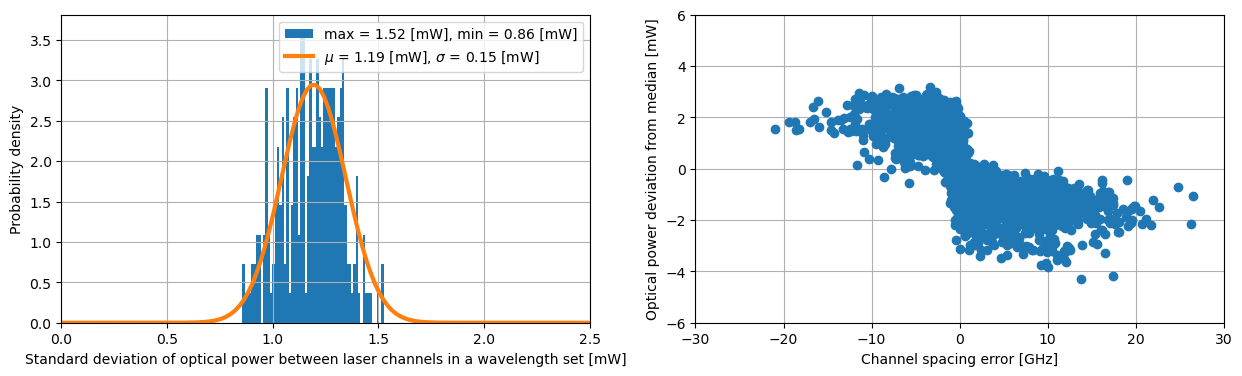

In [58]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
std_ch_optical_power = (np.std(sppd_mc_data['data_statistics_array'].sel(lin_sweep_range = lin_sweep_val_range[0], observable_stat = ' max', controller_observable = 'enablence_output_power').values, axis = -1)).flatten()*10**(-0.05)
param_optimised, x_hist, y_hist = gaussian_quality_2(std_ch_optical_power*1e3, no_bins, x_hist_2=np.linspace(0, 10, num=500))
median_lambda_ch = np.abs(param_optimised[1])
sigma_lambda_ch = np.abs(param_optimised[2])

plt.hist(std_ch_optical_power*1e3, bins = no_bins, density = True, label=f'max = {np.max(std_ch_optical_power)*1e3:.2f} [mW], min = {np.min(std_ch_optical_power)*1e3:.2f} [mW]')
plt.plot(x_hist, y_hist*100, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.2f} [mW], $\sigma$ = {sigma_lambda_ch:.2f} [mW]')
# plt.plot(x_hist_3, y_hist_3, linewidth = 3.0, label = f'$\mu$ = {median_lambda_ch:.1f} [GHz], $\sigma$ = 8 [GHz]')
plt.xlim([0, 2.5])
# plt.ylim([0,2])
plt.grid(True)
plt.xlabel('Standard deviation of optical power between laser channels in a wavelength set [mW]')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_wavelength_error.flatten()/grid_array_diff/0.1*17, single_ch_optical_power_dist.flatten()*1e3, 'o')
plt.xlim([-30, 30])
plt.ylim([-6, 6])
plt.grid(True)
plt.xlabel('Channel spacing error [GHz]')
plt.ylabel('Optical power deviation from median [mW]')

plt.show()